In [ ]:
import scanpy as sc

import pathlib
import numpy as np
import pandas as pd
from tqdm import tqdm 

def read_xenium_adata(xenium_output_folder):
    """Read Xenium Data, along with metadata needed to retrieve IHC and IF data.

    Args:
        output_folder (pathlib.Path): Folder containing xenium data.

    Returns:
        ad.AnnData: Xenium dataset
    """

    # reads in adata
    adata = sc.read_10x_h5(xenium_output_folder / "cell_feature_matrix.h5")
    adata.obs = pd.read_csv(xenium_output_folder / "cells.csv.gz").set_index("cell_id")
    adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

    sc.pp.filter_cells(adata, min_counts=10)
    sc.pp.filter_cells(adata, min_genes=3)
    sc.pp.filter_genes(adata, min_cells=3)

    return adata

folders = [
    pathlib.Path("/oak/stanford/projects/kibr/Reorganizing/Projects/choroid-plexus/data/raw/20240531__205220__Lieber_brain_1_CP_run_2_5-31-24/output-XETG00277__0029343__Region_1__20240531__205229"),
    pathlib.Path("/oak/stanford/projects/kibr/Reorganizing/Projects/choroid-plexus/data/raw/20240531__205220__Lieber_brain_1_CP_run_2_5-31-24/output-XETG00277__0029344__Region_1__20240531__205229"),
    # pathlib.Path("/oak/stanford/projects/kibr/Reorganizing/Projects/choroid-plexus/data/raw/20240510__194358__MA_choroid_plexus_5-10-24/output-XETG00277__0004005__21__20240510__194417")
]

adatas = {
    folder.name: read_xenium_adata(folder) for folder in tqdm(folders)
}

In [2]:
import anndata as ad
adata = ad.concat(adatas, label="folder")
adata.layers["counts"] = adata.X.copy()

/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
adata.shape[0]

446485

In [3]:

adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    layer="counts",
    batch_key="folder"
)


: 

In [ ]:
import scvi
# SCVI
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="folder")
scvi_model = scvi.model.SCVI(adata, n_layers=2, n_latent=30)
scvi_model.train()


: 

In [5]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation()

: 

In [6]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

: 

In [ ]:
sc.pl.umap(adata, color=["folder"])

: 

In [8]:
import sklearn.linear_model

for resolution in tqdm([i/20 for i in range(1, 21)]):
    sc.tl.leiden(adata, resolution = resolution, key_added=f"res_{resolution:.2f}", n_iterations=2, flavor="igraph")

    model = sklearn.linear_model.LogisticRegression(class_weight="balanced")
    model.fit(adata.X, adata.obs[f"res_{resolution:.2f}"])
    score = model.score(adata.X, adata.obs[f"res_{resolution:.2f}"])

    if score > 0.9:
        print(resolution, score)
    else:
        break

  0%|          | 0/20 [00:00<?, ?it/s]/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
  5%|▌         | 1/20 [00:52<16:43, 52.83s/it]

0.05 0.9851551563882325


/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 10%|█         | 2/20 [01:37<14:27, 48.17s/it]

0.1 0.9670380863858808


/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 15%|█▌        | 3/20 [02:26<13:45, 48.55s/it]

0.15 0.9561575416867308


/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 20%|██        | 4/20 [03:16<13:04, 49.05s/it]

0.2 0.9521820441896144


/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 25%|██▌       | 5/20 [04:09<12:36, 50.41s/it]

0.25 0.951906559010941


/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 30%|███       | 6/20 [05:02<12:00, 51.44s/it]

0.3 0.9357805973324972


/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 35%|███▌      | 7/20 [05:56<11:17, 52.11s/it]

0.35 0.934134405411156


/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 40%|████      | 8/20 [06:53<10:43, 53.65s/it]

0.4 0.941077527800486


/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 45%|████▌     | 9/20 [07:51<10:05, 55.06s/it]

0.45 0.9412723831707672


/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 50%|█████     | 10/20 [08:54<09:34, 57.49s/it]

0.5 0.9405041602741413


/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 55%|█████▌    | 11/20 [09:58<08:55, 59.46s/it]

0.55 0.9393260691848551


/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 60%|██████    | 12/20 [11:03<08:08, 61.09s/it]

0.6 0.9351691546188562


/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 65%|██████▌   | 13/20 [12:13<07:26, 63.83s/it]

0.65 0.9340739330548619


/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 70%|███████   | 14/20 [13:20<06:28, 64.75s/it]

0.7 0.9327189043304926


/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 75%|███████▌  | 15/20 [14:30<05:32, 66.54s/it]

0.75 0.9281118066676373


/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 80%|████████  | 16/20 [15:42<04:32, 68.06s/it]

0.8 0.932082824730954


/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 85%|████████▌ | 17/20 [16:53<03:26, 68.84s/it]

0.85 0.9277467328129725


/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 90%|█████████ | 18/20 [18:05<02:19, 69.88s/it]

0.9 0.9269493935966494


/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 95%|█████████▌| 19/20 [19:14<01:09, 69.59s/it]

0.95 0.9241407886043204


/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 20/20 [20:27<00:00, 61.36s/it]

1.0 0.9186713999350482


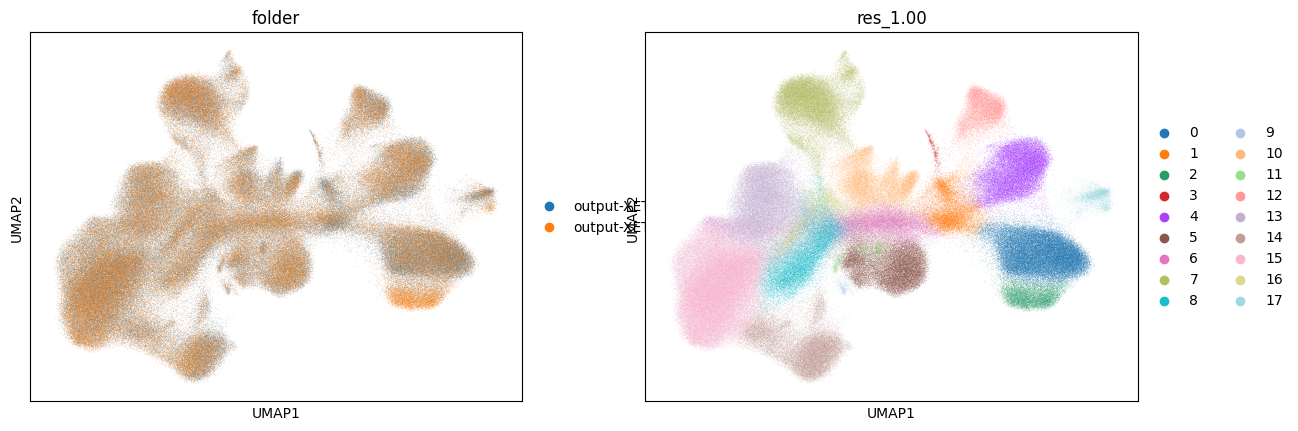

In [9]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=["folder", f"res_{resolution:.2f}"])

/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 352 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


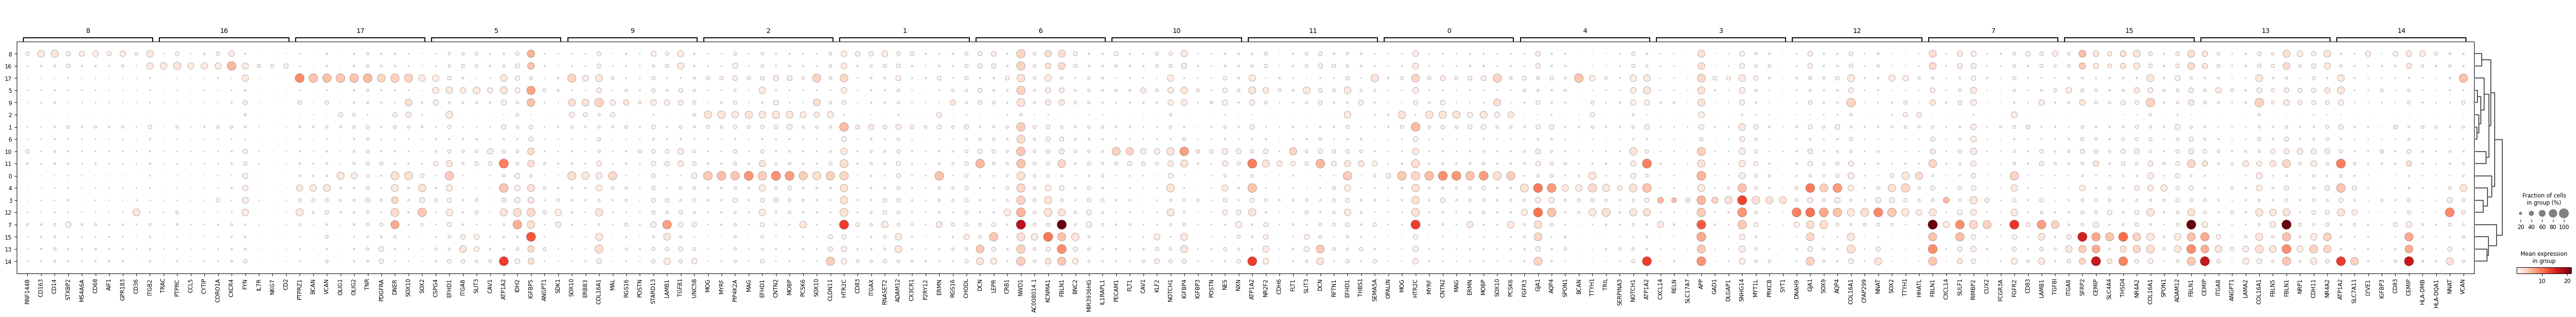

In [10]:
sc.tl.rank_genes_groups(adata, groupby=f"res_{resolution:.2f}", method="logreg")
sc.pl.rank_genes_groups_dotplot(adata)

In [11]:
markers = {}
import pandas as pd
with pd.ExcelWriter("xenium-markers-20Sep2024.xlsx") as writer:
    for cluster in adata.obs.leiden.unique():
        markers[cluster] = sc.get.rank_genes_groups_df(adata, group=cluster)
        markers[cluster].to_excel(writer, sheet_name=cluster)

ModuleNotFoundError: No module named 'openpyxl'

In [37]:
adata_sc = sc.read_h5ad("/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/data/human-ad-filtered.h5ad")

In [38]:
import sklearn.linear_model

model = sklearn.linear_model.SGDClassifier(n_jobs=-1, class_weight="balanced")
model.fit(adata_sc[:, adata.var.index].X, adata_sc.obs["Cell.Subtype"])

SGDClassifier(class_weight='balanced', n_jobs=-1)

In [39]:
adata.obs["predicted_cell_type"] = model.predict(adata.X)

In [40]:
sc.pl.umap(adata, color="predicted_cell_type")

KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

In [41]:
for cluster, row in adata.obs.pivot_table(index=f"res_{resolution:.2f}", columns="predicted_cell_type", aggfunc="size").iterrows():
    print(f"'{cluster}': '{row.index[row.argmax()]}',")

NameError: name 'resolution' is not defined

In [18]:
adata.obs["cell_type"] = adata.obs[f"res_{resolution:.2f}"].replace({
    '0': 'Oligo',
    '1': 'Macrophage',
    '2': 'Oligo',
    '3': 'Neural',
    '4': 'Astro',
    '5': 'Fib-1',
    '6': 'Fib-3',
    '7': 'Epithelial',
    '8': 'Macrophage',
    '9': 'Fib-1',
    '10': 'Endothelial',
    '11': 'Fib-2',
    '12': 'Ependymal',
    '13': 'Fib-1',
    '14': 'Fib-2',
    '15': 'Fib-1',
    '16': 'T cell',
    '17': 'OPC'
})

/tmp/ipykernel_26919/2908250367.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs["cell_type"] = adata.obs[f"res_{resolution:.2f}"].replace({


In [42]:
adata.obs.loc[adata.obs["predicted_cell_type"].isin(["Interneuron", "Neuron", "Inhibitory Neuron"]), "Cell.Subtype"] = "Neuron"


sc.pl.umap(adata, color='predicted_cell_type')

KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

/tmp/ipykernel_10832/2486904116.py:53: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs["Cell.Subtype"] = adata.obs["predicted_cell_type"].replace({


KeyError: 'X_umap'

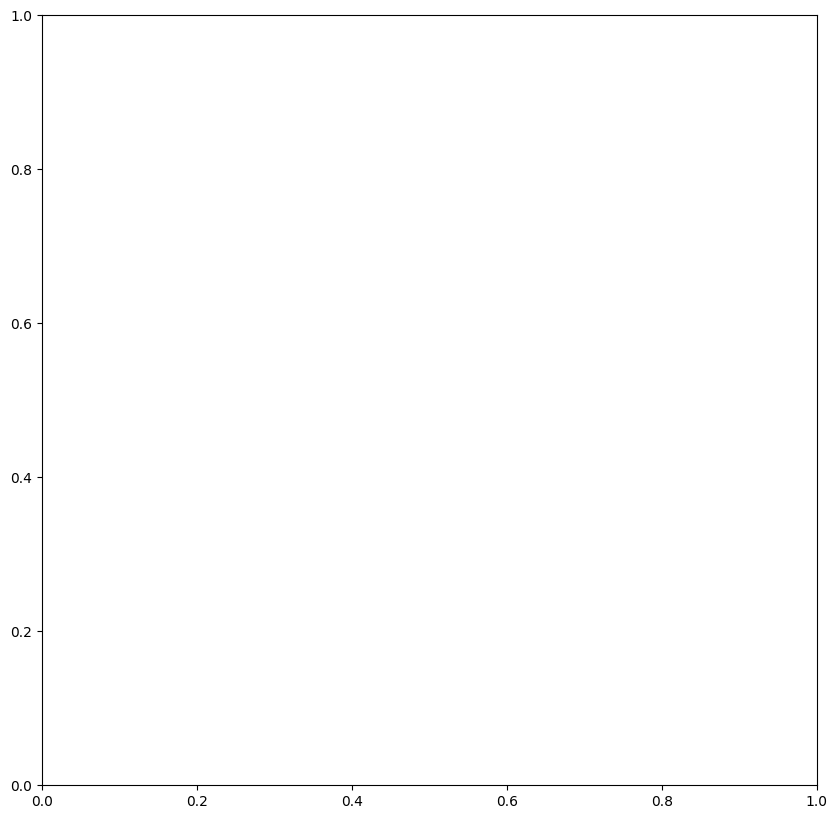

In [43]:
import adjustText
import matplotlib
import matplotlib.pyplot as plt

def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(int(255*r), int(255*g), int(255*b))

tab20_colors = [rgb_to_hex(*x) for x in matplotlib.colormaps["tab20"].colors]

cell_type_colors = {
    "Astrocyte": '#1f77b4',
    "B cell": '#aec7e8',
    "Endothelial": '#ff7f0e',
    "Ependymal": '#ffbb78',
    "Epithelial": '#2ca02c',
    "Fibroblast - 1": '#98df8a',
    "Fibroblast - 2": '#d62728',
    "Fibroblast - 3": '#ff9896',
    "Fibroblast - 4": '#9467bd',
    "Neuron": '#c5b0d5',
    "Macrophage": '#8c564b',
    "Microglia": '#c49c94',
    "NK": '#e377c2',
    "OPC": '#f7b6d2',
    "Oligodendrocyte": '#7f7f7f',
    "T cell": '#c7c7c7'
}

def cell_atlas_study(adata):
    f, ax = plt.subplots(figsize=(10, 10))

    texts = []
    for cell_type in sorted(adata.obs["Cell.Subtype"].unique()):
        coords = adata.obsm["X_umap"][adata.obs["Cell.Subtype"].eq(cell_type)]
        ax.scatter(coords[:, 0], coords[:, 1], color=cell_type_colors[cell_type], s=.5, alpha=0.5)

        x, y = coords.mean(axis=0)


        texts.append(plt.text(x, y, s=f"{cell_type}\n(n = {coords.shape[0]})", bbox=dict(facecolor=cell_type_colors[cell_type], edgecolor='black', boxstyle='round')))

    adjustText.adjust_text(texts,  arrowprops=dict(arrowstyle="-", color='r'))


    # Sugar
    ax.xaxis.set_visible(False)  # Hide x-axis
    ax.yaxis.set_visible(False)  # Hide y-axis

    for spine in ax.spines.values():
        spine.set_visible(False)


adata.obs["Cell.Subtype"] = adata.obs["predicted_cell_type"].replace({
    "Inhibitory Neuron": "Neuron",
    "Interneuron": "Neuron",
    "Neural": "Neuron",
    "Astro": "Astrocyte",
    "Fib-1": "Fibroblast - 1",
    "Fib-2": "Fibroblast - 2",
    "Fib-3": "Fibroblast - 3",
    "Fib-4": "Fibroblast - 4",
    "Oligo": "Oligodendrocyte",
})

cell_atlas_study(adata)

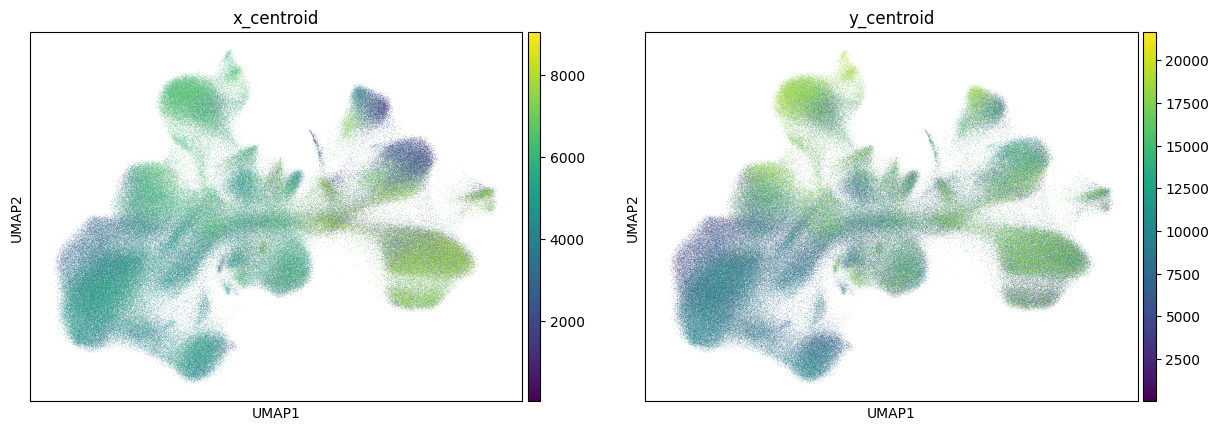

In [73]:
sc.pl.umap(adata, color=["x_centroid", "y_centroid"])

In [2]:
f, ax = plt.subplots(figsize=(10, 20))

texts = []
for cell_type in sorted(adata.obs["Cell.Subtype"].unique()):
    adata[
        adata.obs["folder"].eq(adata.obs["folder"].unique()[0]) &
        adata.obs["Cell.Subtype"].eq(cell_type)
    ].obs.plot.scatter(x="x_centroid", y="y_centroid", c=cell_type_colors[cell_type], ax=ax, s=1)
    x, y = adata[
        adata.obs["folder"].eq(adata.obs["folder"].unique()[0]) &
        adata.obs["Cell.Subtype"].eq(cell_type)
    ].obs[["x_centroid", "y_centroid"]].sample(1).iloc[0].tolist()

    n_cells = adata[
            adata.obs["folder"].eq(adata.obs["folder"].unique()[0]) &
            adata.obs["Cell.Subtype"].eq(cell_type)
    ].obs.shape[0]

    texts.append(plt.text(x, y, s=f"{cell_type}\n(n = {n_cells})", bbox=dict(facecolor=cell_type_colors[cell_type], edgecolor='black', boxstyle='round')))

adjustText.adjust_text(texts,  arrowprops=dict(arrowstyle="-", color='r'))


# Sugar
ax.xaxis.set_visible(False)  # Hide x-axis
ax.yaxis.set_visible(False)  # Hide y-axis

for spine in ax.spines.values():
    spine.set_visible(False)

NameError: name 'plt' is not defined

In [48]:
adata.write_h5ad("/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/notebook/xenium.h5ad")

In [2]:
import scanpy as sc
adata = sc.read_h5ad("/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/notebook/xenium.h5ad")

/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
adata

AnnData object with n_obs × n_vars = 446485 × 352
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts', 'n_genes', 'folder', 'predicted_cell_type', 'Cell.Subtype'
    obsm: 'spatial'
    layers: 'counts'